In [26]:
#%pip install geopandas
#%pip install geoplot
#%pip install statsmodels

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as spy
import statsmodels.api as sm
import geopandas as gpd
import geoplot as gplt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

**Usefull Functions**

In [28]:
## All these funcs assume you have a valid topic and question. Work ONLY on CDC data
def filterTopic(data, topic):
    #Hyunji's data cleaning
    this_data = data[data.Topic.str.contains(topic, na=False)]
    # Remove rows with missing or non-numeric 'DataValue'
    this_data = this_data[pd.to_numeric(this_data.DataValue, errors='coerce').notna()]
    # Convert 'DataValue' to float
    this_data.DataValue = this_data.DataValue.astype(float)
    this_data.reset_index(drop=True, inplace=True)
    # selects only important columns, feel free to add new columns
    return this_data[["YearStart", "LocationAbbr", "Question", "DataValue"]]

def filterQuestion(filteredOnTopic, question, col_rename="DataValue"):
    filteredOnQuestion = filteredOnTopic[filteredOnTopic.Question == question]
    # Removes any territories
    badAbbr = ["GU", "DC", "US", "PR", "VI"]
    filteredOnQuestion = filteredOnQuestion.drop(filteredOnQuestion[filteredOnQuestion.LocationAbbr.isin(badAbbr)].index)
    filteredOnQuestion  = filteredOnQuestion.sort_values(by = ["YearStart", "LocationAbbr"])
    filteredOnQuestion.reset_index(drop=True, inplace=True)
    return filteredOnQuestion[["YearStart", "LocationAbbr", "DataValue"]].rename(columns = {"DataValue": col_rename, "YearStart" : "Year"})

def filterTopicAndQuestion(data, topic, question):
    filteredOnTopic = filterTopic(data, topic)
    return filterQuestion(filteredOnTopic, question)

**Load Usefull Data**

In [29]:
data = pd.read_csv("GLM_Non_Parametric/U.S.Chronic_Disease_Filtered.csv")

In [30]:
cdi_oral = filterTopic(data, "Oral")
cdi_tobacco = filterTopic(data, "Tobacco")
cdi_sleep = filterTopic(data, "Overarching Conditions")
cdi_nutrition = filterTopic(data, "Nutrition, Physical Activity, and Weight Status")

In [31]:
water_data = pd.read_csv("GLM_Non_Parametric/Water_Fluoridation.csv")
water_data = water_data[["Year", "LocationAbbr", "DataValue"]].rename(columns = {"DataValue" : "Fluoridated_Water_pct"})

In [32]:
## I hate how the BEA stores data...
stateAbbr = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
stateNames = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]
df_states = pd.DataFrame(data = {'LocationAbbr': stateAbbr, 'GeoName': stateNames})

income_data = pd.read_csv("GLM_Non_Parametric/Personal_Income.csv", skiprows = [0, 1, 2])
income_data = income_data.drop(["GeoFips", "1998", "1999", "2000", "2001","2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010" , "2023"], axis = 1)
income_data = income_data.drop([0, 9, 52, 53, 54, 55])
income_data = df_states.merge(income_data, left_on = "GeoName", right_on = "GeoName", how = "left")
income_data.drop(columns = ["GeoName"], inplace = True)


**Data Wrangling**

In [33]:
# No tooth loss data
cdi_tooth_loss = filterQuestion(cdi_oral, "No tooth loss among adults aged 18-64 years", "No_Tooth_Loss_18_64_pct")

# No tooth loss data on elders
cdi_elder_tooth_loss = filterQuestion(cdi_oral, "All teeth lost among adults aged >= 65 years", "Complete_Tooth_Loss_65_plus_pct")

# Dentist visits data
cdi_dentist_visits = filterQuestion(cdi_oral, "Visits to dentist or dental clinic among adults aged >= 18 years", "Dentist_Visits_pct")

# Smoking adults data
cdi_smoker = filterQuestion(cdi_tobacco, "Current smoking among adults aged >= 18 years", "Smoke_pct")

# Sleep Duratuon adults data
cdi_short_sleep_duration = filterQuestion(cdi_sleep, "Prevalence of sufficient sleep among adults aged >= 18 years", "Sleep_Duration_pct")

# Obesity adult data
cdi_obesity = filterQuestion(cdi_nutrition, "Obesity among adults aged >= 18 years", "Obesity_pct")

# These features have no (year)overlap with our y values

# Fruit consumption data
#cdi_low_fruit_consumption = filterQuestion(cdi_nutrition, "Median daily frequency of fruit consumption among adults aged >= 18 years", "Fruit_Consumption_pct")

# veggetable consumption data
#cdi_low_veggie_consumption = filterQuestion(cdi_nutrition, "Median daily frequency of vegetable consumption among adults aged >= 18 years", "Veggie_Consumption_pct")

In [34]:
#### DATA HAS NaN values! This is so we can select columns we need and then remove any rows with NaN values, resulting in getting all possible full rows for selection of columns.
## Is there a more efficient way to merge these??
data_wrangled = cdi_tooth_loss.merge(cdi_elder_tooth_loss, left_on = ["Year", "LocationAbbr"], right_on = ["Year", "LocationAbbr"], how = "outer")
data_wrangled = data_wrangled.merge(cdi_dentist_visits, left_on = ["Year", "LocationAbbr"], right_on = ["Year", "LocationAbbr"], how = "outer")
data_wrangled = data_wrangled.merge(cdi_smoker, left_on = ["Year", "LocationAbbr"], right_on = ["Year", "LocationAbbr"], how = "outer")
data_wrangled = data_wrangled.merge(cdi_short_sleep_duration, left_on = ["Year", "LocationAbbr"], right_on = ["Year", "LocationAbbr"], how = "outer")
data_wrangled = data_wrangled.merge(cdi_obesity, left_on = ["Year", "LocationAbbr"], right_on = ["Year", "LocationAbbr"], how = "outer")
# These features have no (year) overlap with our y values 
#data_wrangled = data_wrangled.merge(cdi_low_fruit_consumption, left_on = ["Year", "LocationAbbr"], right_on = ["Year", "LocationAbbr"], how = "outer")
#data_wrangled = data_wrangled.merge(cdi_low_veggie_consumption, left_on = ["Year", "LocationAbbr"], right_on = ["Year", "LocationAbbr"], how = "outer")
data_wrangled = data_wrangled.merge(water_data, left_on = ["Year", "LocationAbbr"], right_on = ["Year", "LocationAbbr"], how = "outer")
data_wrangled = data_wrangled.sort_values(by = ["Year", "LocationAbbr"])
data_wrangled.dropna(subset=["No_Tooth_Loss_18_64_pct", "Complete_Tooth_Loss_65_plus_pct"], how = "all", inplace=True)
data_wrangled.reset_index(drop=True, inplace=True)

In [35]:
# These are years for which we have either y1 or y2 data (no tooth loss or complete tooth loss)
data_wrangled.Year.unique()

array([2012, 2014, 2016, 2018, 2020])

In [36]:
income_lis = []
for col in data_wrangled.Year.unique():
    income_lis = np.append(income_lis, income_data[str(col)].values)
data_wrangled["Avg_Personal_Income"] = income_lis
data_wrangled.head()

,Year,LocationAbbr,No_Tooth_Loss_18_64_pct,Complete_Tooth_Loss_65_plus_pct,Dentist_Visits_pct,Smoke_pct,Sleep_Duration_pct,Obesity_pct,Fluoridated_Water_pct,Avg_Personal_Income
0,2012,AK,64.3,16.1,67.3,20.0,62.1,25.7,52.9,41617.0
1,2012,AL,52.2,23.8,58.4,24.4,NaN,32.8,78.4,55069.0
2,2012,AR,54.8,24.0,54.7,25.7,NaN,35.1,66.9,39253.0
3,2012,AZ,61.0,13.8,61.1,17.2,NaN,26.3,57.8,43016.0
4,2012,CA,64.3,8.8,66.8,12.5,NaN,25.0,63.7,46170.0


**GLM HERE**

In [37]:
def selectCols(features, data = data_wrangled):
    data = data[features].dropna()
    return data

def runModel(x_train, x_test, y_train, y_test):
    x_train = sm.add_constant(x_train)
    
    poisson_model = sm.GLM(y_train, x_train, family=sm.families.Poisson())
    poisson_results = poisson_model.fit()
    print(poisson_results.summary())
    print("Model with Poisson AIC :" + str(poisson_results.aic))
    
    negbin_model = sm.GLM(y_train, x_train, family=sm.families.NegativeBinomial())
    negbin_results = negbin_model.fit()
    print(negbin_results.summary())
    print("Model with NegBin AIC :" + str(negbin_results.aic))
    
    gamma_model = sm.GLM(y_train, x_train, family=sm.families.Gamma())
    gamma_results = gamma_model.fit()
    print(gamma_results.summary())
    print("Model with Gamma AIC :" + str(gamma_results.aic))

    predict1 = poisson_results.predict(sm.add_constant(x_test))
    differences1 = predict1.values - y_test.values

    predict2 = negbin_results.predict(sm.add_constant(x_test))
    differences2 = predict2.values - y_test.values

    predict3 = gamma_results.predict(sm.add_constant(x_test))
    differences3 = predict3.values - y_test.values
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
    
    ax1.hist(differences1, histtype= "bar", density = True)
    ax1.set_title("Poisson")
    ax1.axvline(differences1.mean(), color='k', linestyle='dashed', linewidth=1, label = "Poisson mean = " + str(differences1.mean()))
    ax1.axvline(differences1.var(), color='k', linestyle=':', linewidth=1, label = "Poisson var = " + str(differences1.var()))
    ax1.axvline(-differences1.var(), color='k', linestyle=':', linewidth=1)
    ax1.legend()
    
    ax2.hist(differences2, histtype= "bar", density = True)
    ax2.set_title("NegBin")
    ax2.axvline(differences2.mean(), color='k', linestyle='dashed', linewidth=1, label = "NegBin mean = " + str(differences2.mean()))
    ax2.axvline(differences2.var(), color='k', linestyle=':', linewidth=1, label = "NegBin var = " + str(differences2.var()))
    ax2.axvline(-differences2.var(), color='k', linestyle=':', linewidth=1)
    ax2.legend()

    ax3.hist(differences3, histtype= "bar", density = True)
    ax3.set_title("Gamma")
    ax3.axvline(differences3.mean(), color='k', linestyle='dashed', linewidth=1, label = "Gamma mean = " + str(differences3.mean()))
    ax3.axvline(differences3.var(), color='k', linestyle=':', linewidth=1, label = "Gamma var = " + str(differences3.var()))
    ax3.axvline(-differences3.var(), color='k', linestyle=':', linewidth=1)
    ax3.legend()

**Simple Models**

In [38]:
## Can now filter data to columns needed for any given model
simple_data_1 = selectCols(["Year", "LocationAbbr", "No_Tooth_Loss_18_64_pct", "Dentist_Visits_pct", "Smoke_pct"])
simple_data_1.head()

,Year,LocationAbbr,No_Tooth_Loss_18_64_pct,Dentist_Visits_pct,Smoke_pct
0,2012,AK,64.3,67.3,20.0
1,2012,AL,52.2,58.4,24.4
2,2012,AR,54.8,54.7,25.7
3,2012,AZ,61.0,61.1,17.2
4,2012,CA,64.3,66.8,12.5


                    Generalized Linear Model Regression Results                    
Dep. Variable:     No_Tooth_Loss_18_64_pct   No. Observations:                  200
Model:                                 GLM   Df Residuals:                      197
Model Family:                      Poisson   Df Model:                            2
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -614.00
Date:                     Wed, 03 Jul 2024   Deviance:                       28.711
Time:                             16:55:07   Pearson chi2:                     28.5
No. Iterations:                          3   Pseudo R-squ. (CS):             0.2392
Covariance Type:                 nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

/Users/hyunji/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


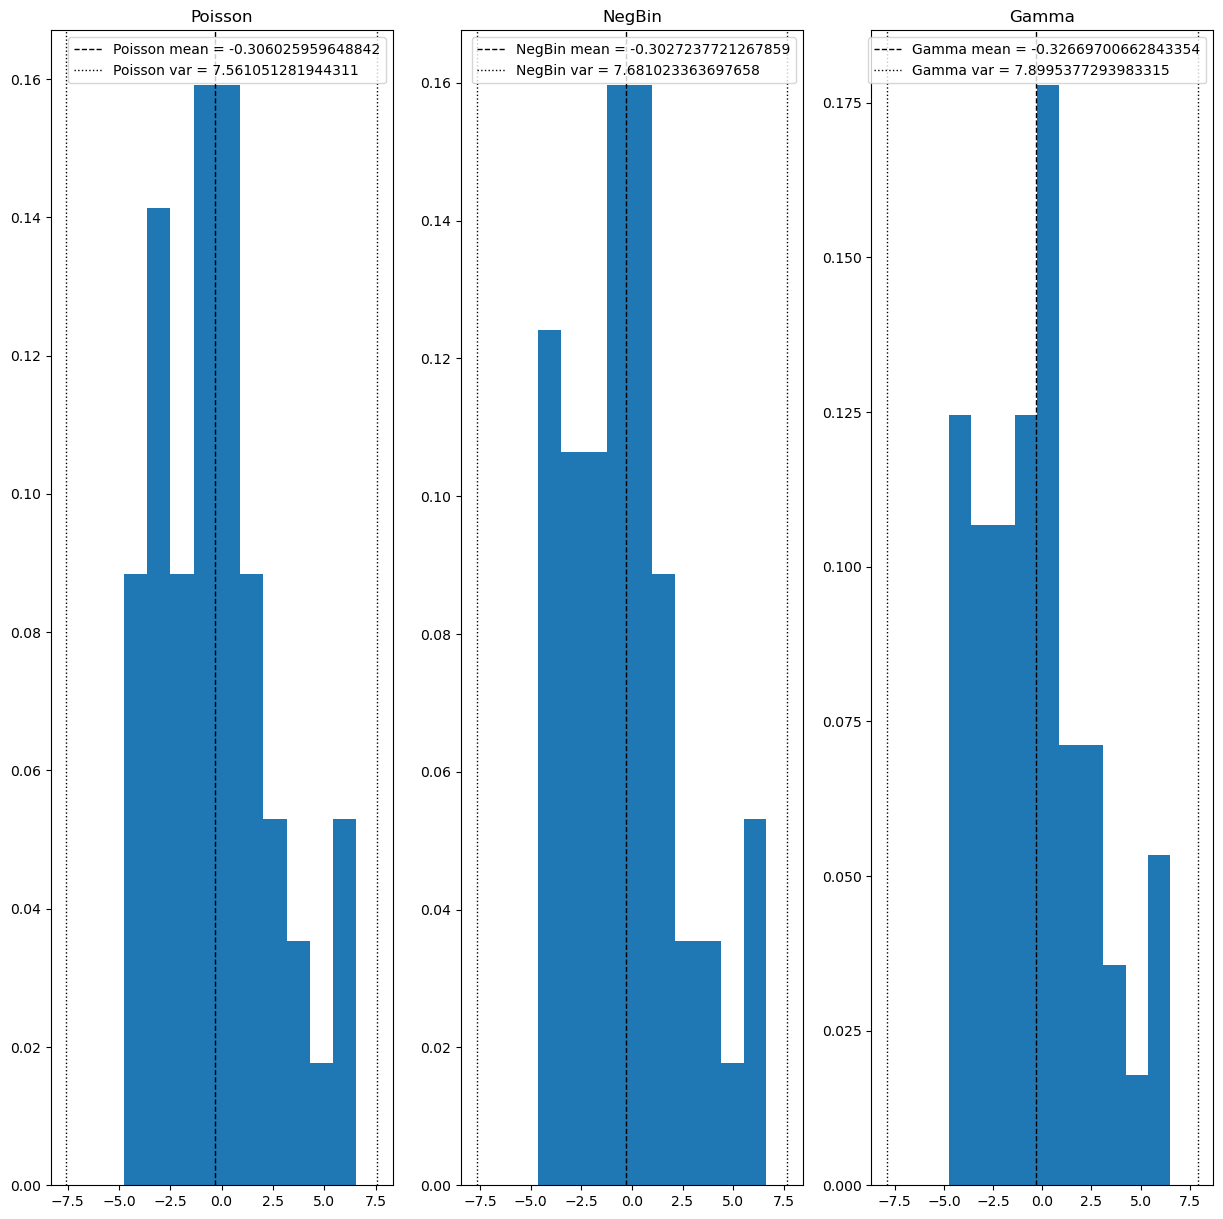

In [39]:
simple_data_1 = selectCols(["Year", "LocationAbbr", "No_Tooth_Loss_18_64_pct", "Dentist_Visits_pct", "Smoke_pct"])
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(simple_data_1[["Dentist_Visits_pct", "Smoke_pct"]], simple_data_1["No_Tooth_Loss_18_64_pct"], train_size=0.8)
runModel(x_train_1, x_test_1, y_train_1, y_test_1 )

                    Generalized Linear Model Regression Results                    
Dep. Variable:     No_Tooth_Loss_18_64_pct   No. Observations:                  123
Model:                                 GLM   Df Residuals:                      119
Model Family:                      Poisson   Df Model:                            3
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -380.70
Date:                     Wed, 03 Jul 2024   Deviance:                       23.435
Time:                             16:55:08   Pearson chi2:                     23.2
No. Iterations:                          3   Pseudo R-squ. (CS):             0.1323
Covariance Type:                 nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

/Users/hyunji/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


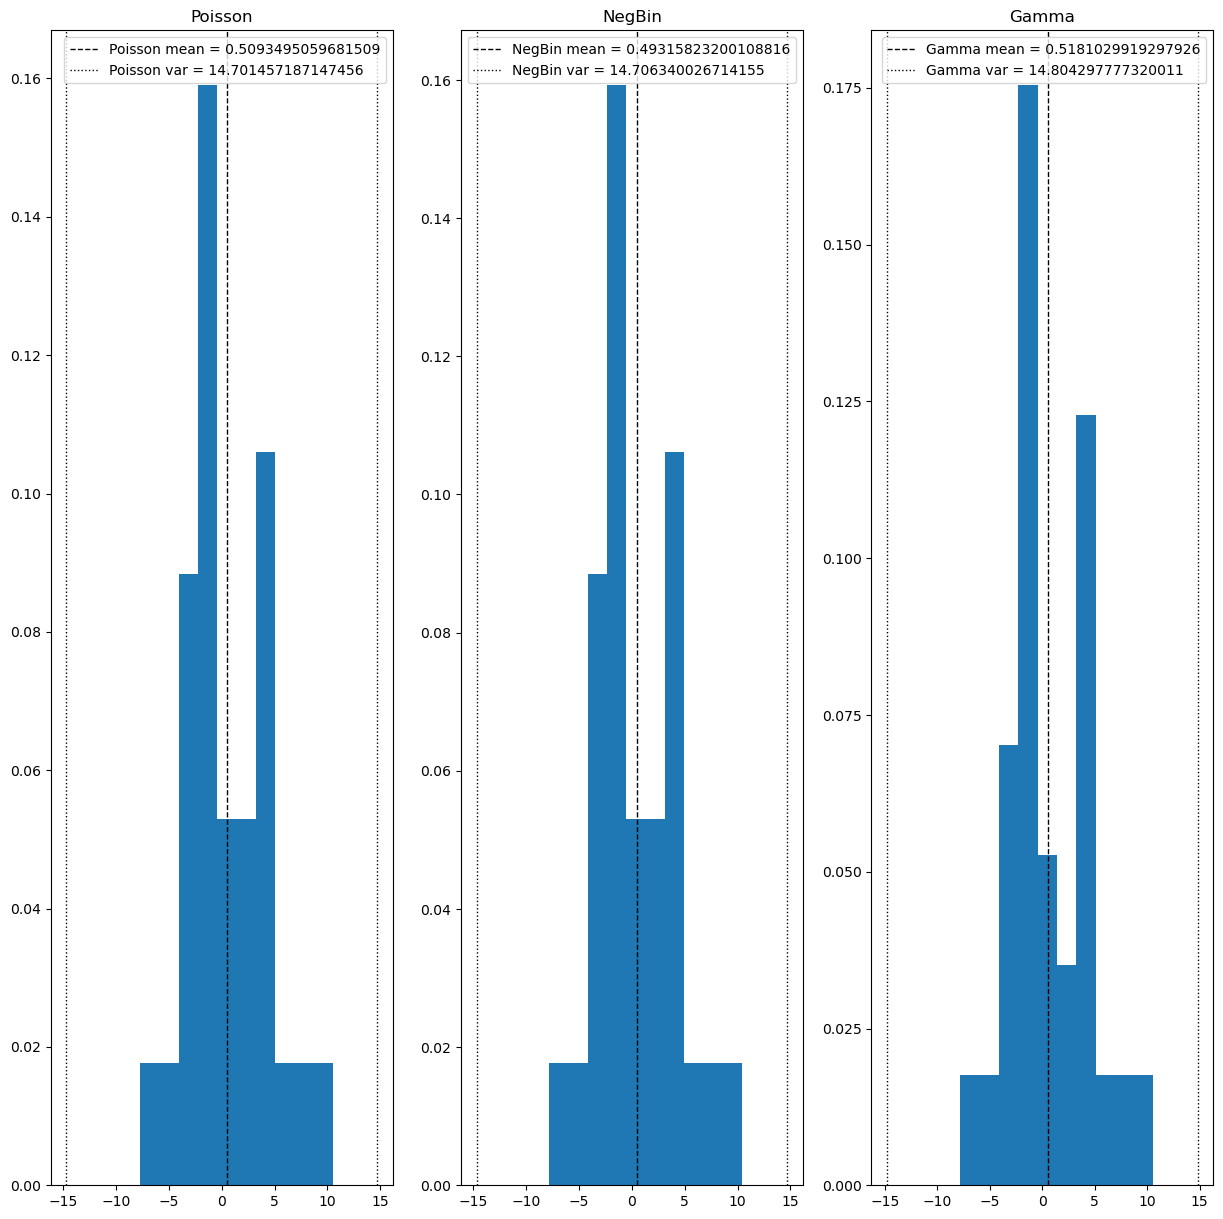

In [40]:
simple_data_2 = selectCols(["Year", "LocationAbbr", "No_Tooth_Loss_18_64_pct", "Obesity_pct", "Sleep_Duration_pct", "Fluoridated_Water_pct"])
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(simple_data_2[[ "Obesity_pct", "Sleep_Duration_pct", "Fluoridated_Water_pct"]], simple_data_2["No_Tooth_Loss_18_64_pct"], train_size=0.8)
runModel(x_train_1, x_test_1, y_train_1, y_test_1 )

                    Generalized Linear Model Regression Results                    
Dep. Variable:     No_Tooth_Loss_18_64_pct   No. Observations:                  200
Model:                                 GLM   Df Residuals:                      197
Model Family:                      Poisson   Df Model:                            2
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -619.06
Date:                     Wed, 03 Jul 2024   Deviance:                       38.692
Time:                             16:55:08   Pearson chi2:                     38.4
No. Iterations:                          3   Pseudo R-squ. (CS):             0.1880
Covariance Type:                 nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

/Users/hyunji/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


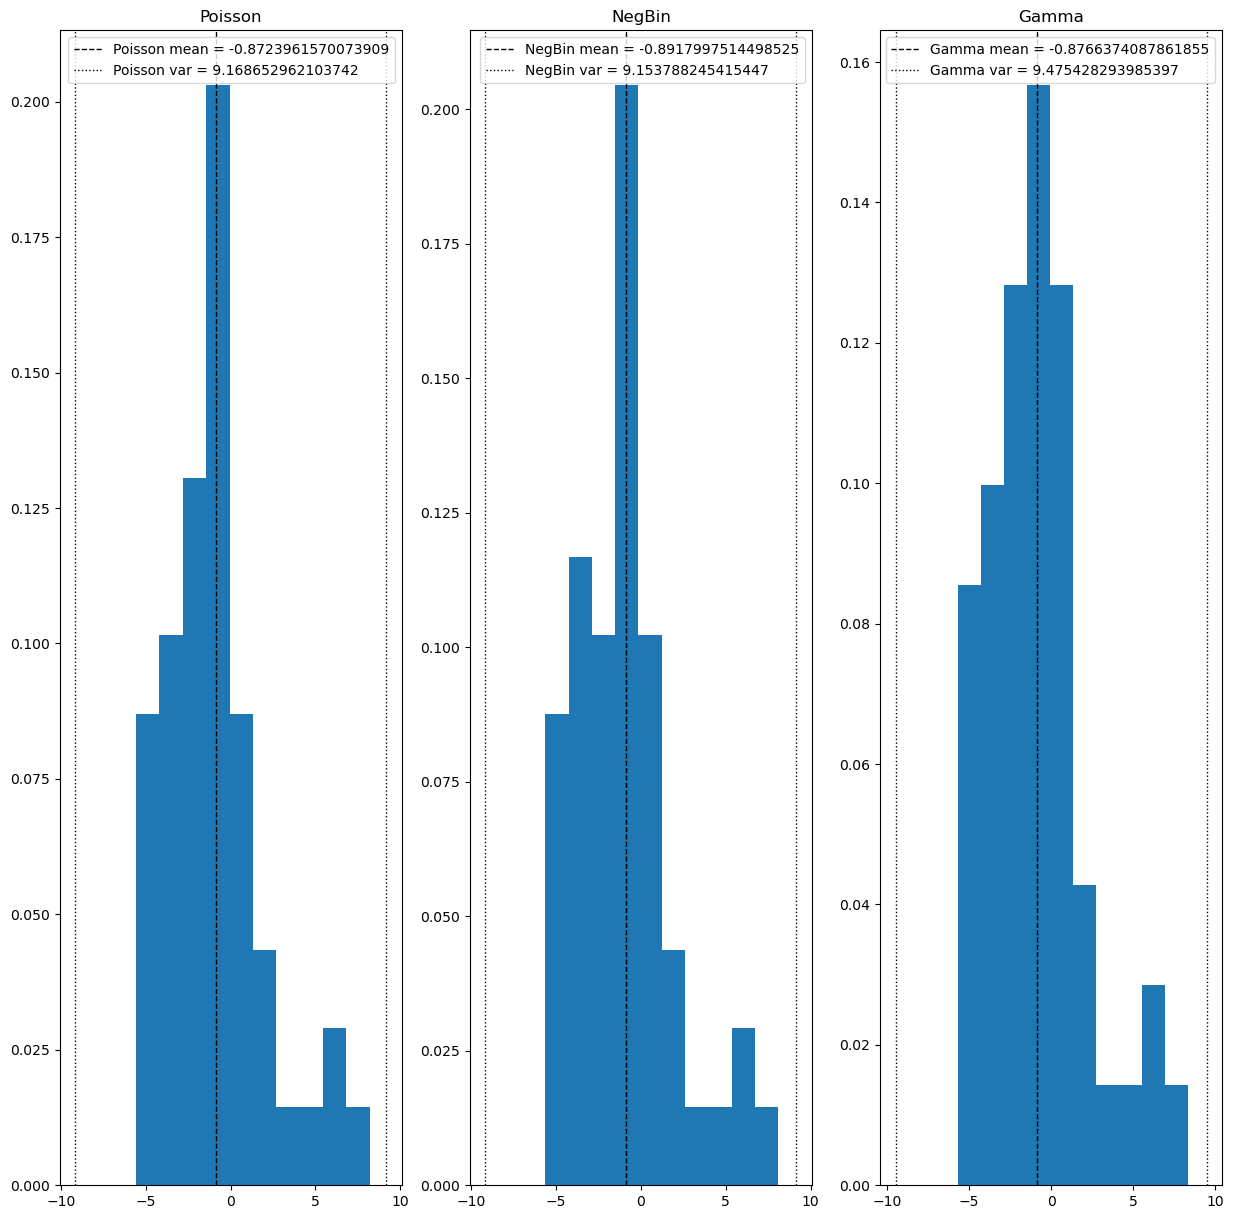

In [41]:
simple_data_3 = selectCols(["Year", "LocationAbbr", "No_Tooth_Loss_18_64_pct", "Dentist_Visits_pct", "Avg_Personal_Income"])
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(simple_data_3[[ "Dentist_Visits_pct", "Avg_Personal_Income"]], simple_data_3["No_Tooth_Loss_18_64_pct"], train_size=0.8)
runModel(x_train_1, x_test_1, y_train_1, y_test_1 )

                    Generalized Linear Model Regression Results                    
Dep. Variable:     No_Tooth_Loss_18_64_pct   No. Observations:                  163
Model:                                 GLM   Df Residuals:                      159
Model Family:                      Poisson   Df Model:                            3
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -497.98
Date:                     Wed, 03 Jul 2024   Deviance:                       17.099
Time:                             16:55:09   Pearson chi2:                     16.9
No. Iterations:                          3   Pseudo R-squ. (CS):             0.2216
Covariance Type:                 nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

/Users/hyunji/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


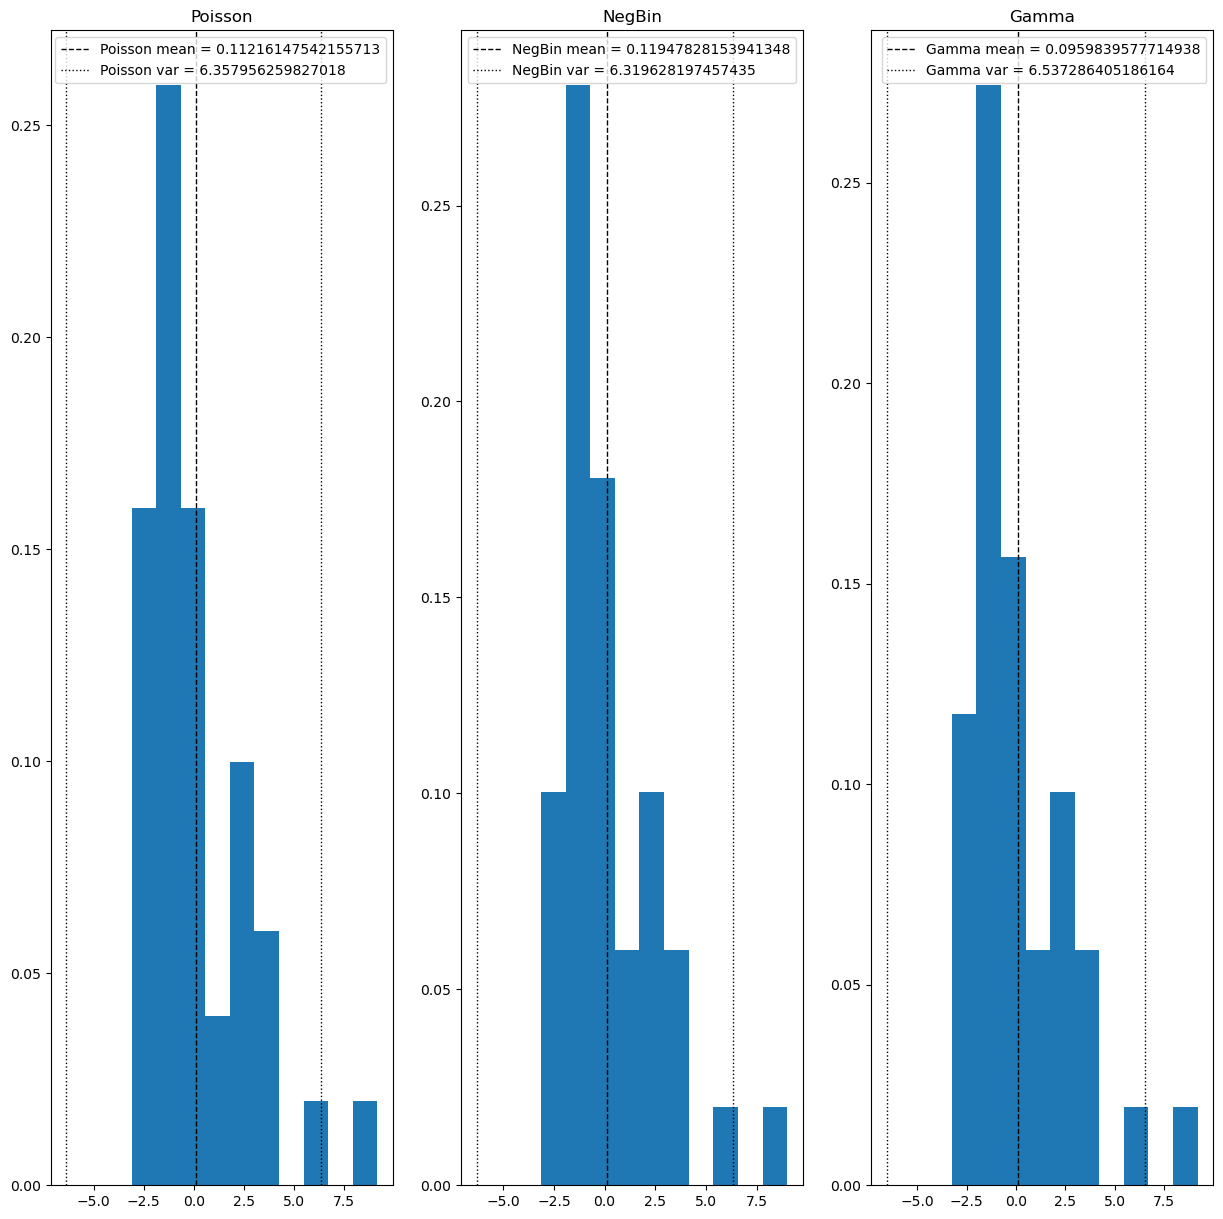

In [42]:
simple_data_4 = selectCols(["Year", "LocationAbbr", "No_Tooth_Loss_18_64_pct", "Obesity_pct", "Sleep_Duration_pct", "Dentist_Visits_pct"])
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(simple_data_4[[ "Obesity_pct", "Sleep_Duration_pct", "Dentist_Visits_pct"]], simple_data_4["No_Tooth_Loss_18_64_pct"], train_size=0.8)
runModel(x_train_1, x_test_1, y_train_1, y_test_1 )

**Complex Models**

                    Generalized Linear Model Regression Results                    
Dep. Variable:     No_Tooth_Loss_18_64_pct   No. Observations:                  163
Model:                                 GLM   Df Residuals:                      158
Model Family:                      Poisson   Df Model:                            4
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -496.58
Date:                     Wed, 03 Jul 2024   Deviance:                       14.284
Time:                             16:55:09   Pearson chi2:                     14.1
No. Iterations:                          3   Pseudo R-squ. (CS):             0.2372
Covariance Type:                 nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

/Users/hyunji/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


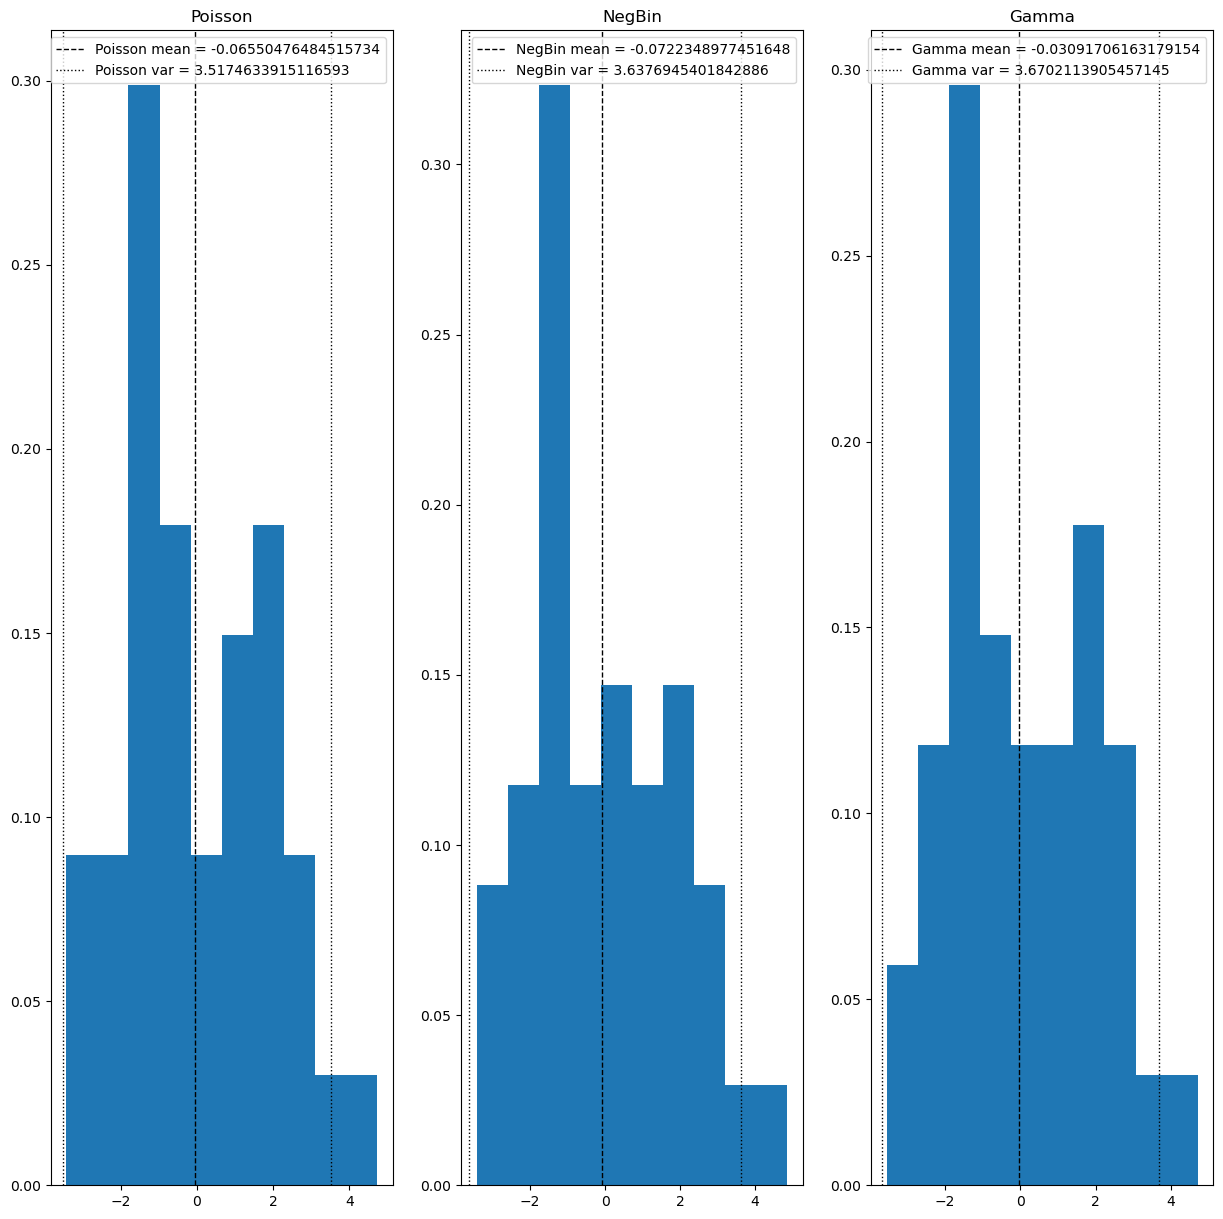

In [43]:
complex_data_1 = selectCols(["Year", "LocationAbbr", "No_Tooth_Loss_18_64_pct", "Dentist_Visits_pct", "Smoke_pct", "Obesity_pct", "Sleep_Duration_pct"])
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(complex_data_1[[ "Dentist_Visits_pct", "Smoke_pct", "Obesity_pct", "Sleep_Duration_pct"]], complex_data_1["No_Tooth_Loss_18_64_pct"], train_size=0.8)
runModel(x_train_1, x_test_1, y_train_1, y_test_1 )

                    Generalized Linear Model Regression Results                    
Dep. Variable:     No_Tooth_Loss_18_64_pct   No. Observations:                  123
Model:                                 GLM   Df Residuals:                      116
Model Family:                      Poisson   Df Model:                            6
Link Function:                         Log   Scale:                          1.0000
Method:                               IRLS   Log-Likelihood:                -373.60
Date:                     Wed, 03 Jul 2024   Deviance:                       9.6080
Time:                             16:55:09   Pearson chi2:                     9.48
No. Iterations:                          3   Pseudo R-squ. (CS):             0.2254
Covariance Type:                 nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

/Users/hyunji/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


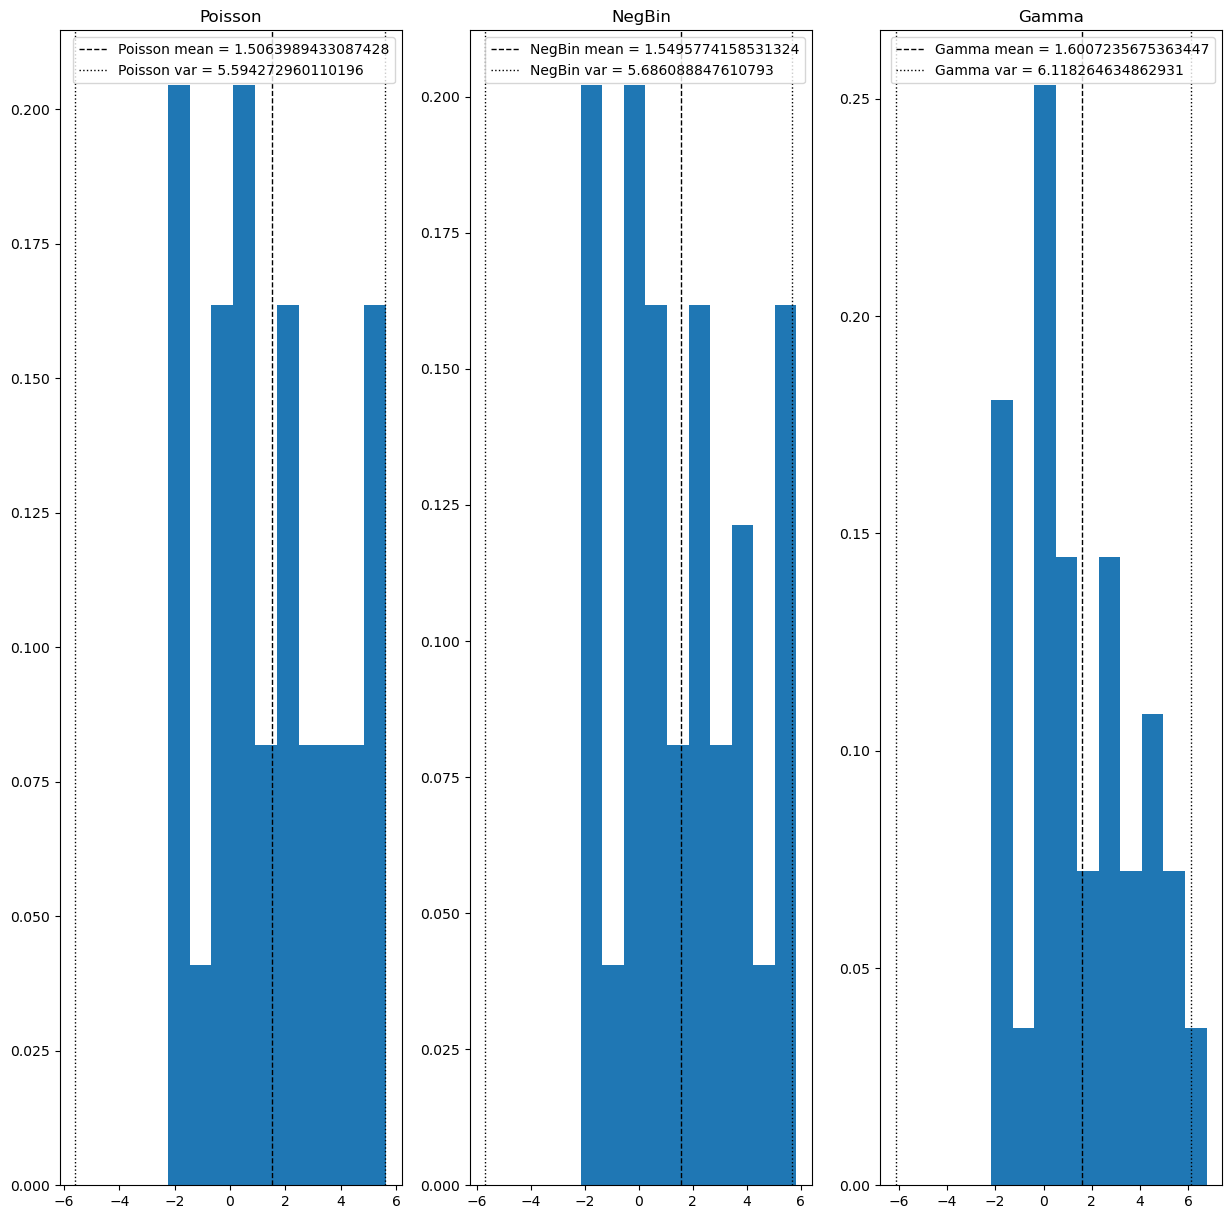

In [44]:
complex_data_2 = selectCols(["Year", "LocationAbbr", "No_Tooth_Loss_18_64_pct", "Dentist_Visits_pct", "Smoke_pct", "Obesity_pct", "Sleep_Duration_pct", "Fluoridated_Water_pct", "Avg_Personal_Income"])
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(complex_data_2[[ "Dentist_Visits_pct", "Smoke_pct", "Obesity_pct", "Sleep_Duration_pct", "Fluoridated_Water_pct", "Avg_Personal_Income"]], complex_data_2["No_Tooth_Loss_18_64_pct"], train_size=0.8)
runModel(x_train_1, x_test_1, y_train_1, y_test_1 )

# Ordinary Least Squares regression (OLS)

In [23]:
import statsmodels.api as sm
def ordinary_least_squares_regression(dataframe, target_variable, explanatory_variables, intercept = False):
    inputs = dataframe[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    return(sm.OLS(dataframe[target_variable], inputs).fit())

The different analyses are as follows.

**Single Parameter (With "No_Tooth_Loss_18_64_pct"):**

**1)** "No_Tooth_Loss_18_64_pct" vs. "Complete_Tooth_Loss_65_plus_pct"

**2)** "No_Tooth_Loss_18_64_pct" vs. "Dentist_Visits_for_Adults_pct"

**3)** "No_Tooth_Loss_18_64_pct" vs. "Adults_who_Smoke_pct"

**4)** "No_Tooth_Loss_18_64_pct" vs. "Adults_who_have_Short_Sleep_Duration_pct"

**5)** "No_Tooth_Loss_18_64_pct" vs. "Adults_who_have_Obesity_pct"

**Two Paramaters (With "No_Tooth_Loss_18_64_pct"):**

**_With "Complete_Tooth_Loss_65_plus_pct":_**

**1)** "No_Tooth_Loss_18_64_pct" vs. ["Complete_Tooth_Loss_65_plus_pct", "Dentist_Visits_for_Adults_pct"]

**2)** "No_Tooth_Loss_18_64_pct" vs. ["Complete_Tooth_Loss_65_plus_pct", "Adults_who_Smoke_pct"]

**3)** "No_Tooth_Loss_18_64_pct" vs. ["Complete_Tooth_Loss_65_plus_pct", "Adults_who_have_Short_Sleep_Duration_pct"]

**4)** "No_Tooth_Loss_18_64_pct" vs. ["Complete_Tooth_Loss_65_plus_pct", "Adults_who_have_Obesity_pct"]

**_With "Dentist_Visits_for_Adults_pct":_**

**1)** "No_Tooth_Loss_18_64_pct" vs. ["Dentist_Visits_for_Adults_pct", "Adults_who_Smoke_pct"]

**2)** "No_Tooth_Loss_18_64_pct" vs. ["Dentist_Visits_for_Adults_pct", "Adults_who_have_Short_Sleep_Duration_pct"]

**3)** "No_Tooth_Loss_18_64_pct" vs. ["Dentist_Visits_for_Adults_pct", "Adults_who_have_Obesity_pct"]

**_With "Adults_who_Smoke_pct":_**

**1)** "No_Tooth_Loss_18_64_pct" vs. ["Adults_who_Smoke_pct", "Adults_who_have_Short_Sleep_Duration_pct"]

**2)** "No_Tooth_Loss_18_64_pct" vs. ["Adults_who_Smoke_pct", "Adults_who_have_Obesity_pct"]

**_With "Adults_who_have_Short_Sleep_Duration_pct":_**

**1)** "No_Tooth_Loss_18_64_pct" vs. ["Adults_who_have_Short_Sleep_Duration_pct", "Adults_who_have_Obesity_pct"]

### Non-parametric Models

In [25]:
data = simple_data_1.copy()

X = data.drop(['Year', 'LocationAbbr', 'No_Tooth_Loss_18_64_pct'], axis=1)
y = data['No_Tooth_Loss_18_64_pct']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Building and training a Decision Tree regression model
decision_tree_regressor = DecisionTreeRegressor(random_state=42)
decision_tree_regressor.fit(X_train, y_train)

# Building and training a Random Forest regression model
random_forest_regressor = RandomForestRegressor(random_state=42)
random_forest_regressor.fit(X_train, y_train)

# Evaluating model performance on training data
dt_train_predictions = decision_tree_regressor.predict(X_train)
dt_train_rmse = mean_squared_error(y_train, dt_train_predictions, squared=False)
dt_train_r2 = r2_score(y_train, dt_train_predictions)

rf_train_predictions = random_forest_regressor.predict(X_train)
rf_train_rmse = mean_squared_error(y_train, rf_train_predictions, squared=False)
rf_train_r2 = r2_score(y_train, rf_train_predictions)

# Evaluating model performance on test data
dt_test_predictions = decision_tree_regressor.predict(X_test)
dt_test_rmse = mean_squared_error(y_test, dt_test_predictions, squared=False)
dt_test_r2 = r2_score(y_test, dt_test_predictions)

rf_test_predictions = random_forest_regressor.predict(X_test)
rf_test_rmse = mean_squared_error(y_test, rf_test_predictions, squared=False)
rf_test_r2 = r2_score(y_test, rf_test_predictions)

# Cross-validation
dt_cv_rmse_scores = cross_val_score(decision_tree_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
rf_cv_rmse_scores = cross_val_score(random_forest_regressor, X, y, cv=5, scoring='neg_mean_squared_error')

# Printing results
print("Decision Tree Training RMSE:", dt_train_rmse, "Training R2:", dt_train_r2)
print("Decision Tree Test RMSE:", dt_test_rmse, "Test R2:", dt_test_r2)
print("Decision Tree Cross-validation RMSE:", (-dt_cv_rmse_scores.mean())**0.5)

print("Random Forest Training RMSE:", rf_train_rmse, "Training R2:", rf_train_r2)
print("Random Forest Test RMSE:", rf_test_rmse, "Test R2:", rf_test_r2)
print("Random Forest Cross-validation RMSE:", (-rf_cv_rmse_scores.mean())**0.5)


Decision Tree Training RMSE: 0.18708286933869708 Training R2: 0.9986365995187398
Decision Tree Test RMSE: 3.9766820340580415 Test R2: 0.27333596048682707
Decision Tree Cross-validation RMSE: 3.8532856110078306
Random Forest Training RMSE: 1.0919727521274931 Training R2: 0.9535507183595311
Random Forest Test RMSE: 3.0840837131808514 Test R2: 0.5629367910771783
Random Forest Cross-validation RMSE: 3.15988942400152


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=02bc2dab-94cb-4b89-94f3-d2a5d64fe0b1' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>